In [1]:
import pandas as pd
import urllib
import numpy as np
import os
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import json

import utils

## Downloading dataset

In [2]:
df = utils.download_data(filename='dataset.csv')
df

dataset.csv already exists in the current directory.


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.28910,True
1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.93330,True
2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.59690,True
3,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.01220,True
4,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.57260,True
...,...,...,...,...,...,...,...,...,...,...
4630,CHEMBL120564,2.600000e+06,nM,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,214.074228,4,1,2.13978,True
4631,CHEMBL66879,3.000000e+06,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879,164.047344,2,2,1.49000,True
4632,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,404.095250,6,1,5.20048,True
4633,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,172.063663,3,1,1.59806,True


In [3]:
df = df[["molecule_chembl_id", "smiles", "pIC50"]]
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 8.0, 0 otherwise
pIC50_cut_off = 8.0
df.loc[df[df.pIC50 >= pIC50_cut_off].index, "active"] = 1.0
df

C:\Users\mehra\AppData\Local\Temp\ipykernel_20172\1884176641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["active"] = np.zeros(len(df))


,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0
...,...,...,...,...
4630,CHEMBL120564,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0
4631,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0
4632,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0
4633,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0


## Molecule encoding

In [10]:
# This takes forever to run, so just loading the pickled file!
morderd_file = 'saved_results/cleaned_up_mordred_descriptors.pkl'
if not os.path.exists(morderd_file):
    df['mordred'] = df["smiles"].apply(utils.smiles_to_descriptors, type='mordred')
    df['mordred'] = [list(array[0]) for array in df['mordred']]
    mordred_array = np.vstack(df['mordred'])
    # Identify columns with NaN values
    nan_columns = np.isnan(np.vstack(df['mordred'])).any(axis=0)
    # Extract columns without NaN values
    mordred_array_without_nan = mordred_array[:, ~nan_columns]
    # dropping features with 0 std
    mask = mordred_array_without_nan.std(axis=0) != 0
    mordred_array_without_nan = mordred_array_without_nan[:, mask]
    df['mordred'] = mordred_array_without_nan.tolist()
    df['mordred'].to_pickle(morderd_file)
else:
    df['mordred'] = pd.read_pickle(morderd_file)
mordred_features = np.vstack(df['mordred'])

C:\Users\mehra\AppData\Local\Temp\ipykernel_20172\830990368.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mordred'] = pd.read_pickle('mordred_descriptors.pkl')


## Visualizing Pearson Correlation

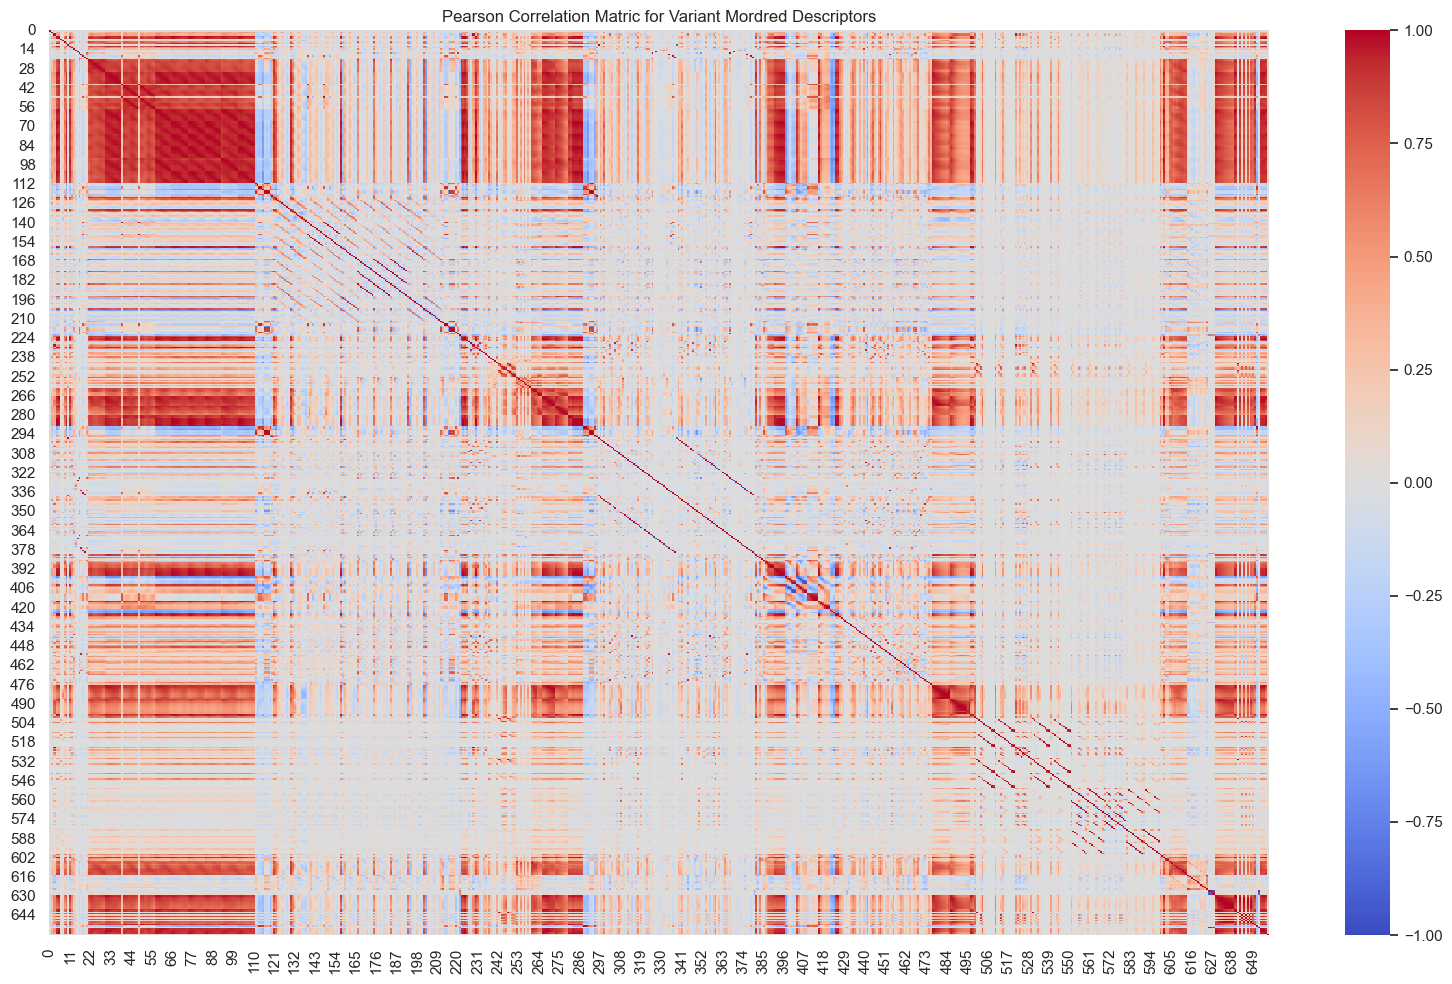

In [38]:
correlation_matrix = np.corrcoef(mordred_features, df['active'], rowvar=False)
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(correlation_matrix, annot = False, fmt='.2g',cmap= 'coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matric for Variant Mordred Descriptors')
plt.tight_layout()
plt.savefig('img/Pearson_Mordred_features.png', dpi=300)

## Recursive Feature Elimination (RFE)

In [20]:
# This cell takes a while to run!

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sklearn.metrics import make_scorer, roc_auc_score
test_scores = []

min_n_features = 10
selected_features_indices = []
max_n_features = 300

RF_param = {
"n_estimators": 50,  # number of trees to grows
"criterion": "entropy",  # loss function to be optimized for a split
}


X = mordred_features
y = df['active']

saving_path = 'saved_results/Mordred_recursive_feature_selection.json'

if not os.path.exists(saving_path):

    for m in tqdm(range(min_n_features, max_n_features, 10)):
        SEED = None
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
        # scale features
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Create the RFE model and select the top m features
    
        from sklearn.ensemble import RandomForestClassifier
        model_RF = RandomForestClassifier(**RF_param)
        selector = RFE(model_RF, n_features_to_select=m, step=0.2)
        selector = selector.fit(X_train, y_train)
        
        # Selected features
        selected_features = np.where(selector.support_)[0]
        selected_features_indices.append(selected_features)
        # print("Selected features:", selected_features)
        
        # Test the model
        y_pred_probs = selector.estimator_.predict_proba(X_test[:, selected_features])[:, 1]
        score = roc_auc_score(y_test, y_pred_probs)
        test_scores.append(score)
        # print(f"Test accuracy: {score:.3f}")
    
    
    RFE_dict = [{"Number of features": len(selected_features_indices[i]),
             "AUC Score": np.round(test_scores[i],3), "Selected Mordred features indices":selected_features_indices[i].tolist() }
            for i, m in enumerate(test_scores)]
    
    
    with open(saving_path, 'w') as f:
        json.dump(RFE_dict, f, indent=4)
else:
    with open(saving_path, 'r') as f:
        RFE_dict = json.load(f)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 29/29 [39:18<00:00, 81.33s/it]


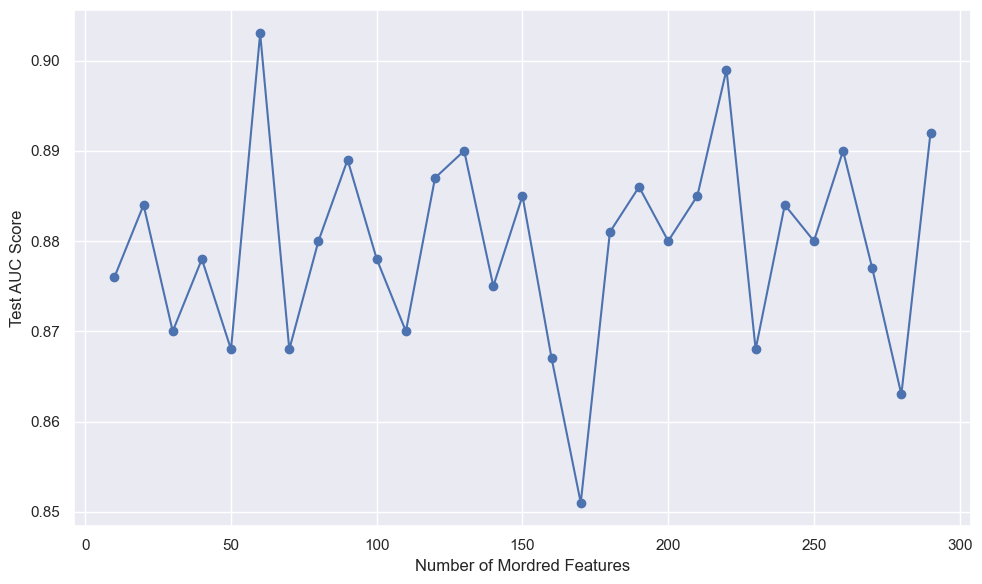

In [33]:
import matplotlib.pyplot as plt

# Extracting data and plotting
plt.figure(figsize=(10, 6))
plt.plot(
    [entry["Number of features"] for entry in dict], 
    [entry["AUC Score"] for entry in dict], 
    marker='o'
)
plt.xlabel('Number of Mordred Features')
plt.ylabel('Test AUC Score')

plt.tight_layout()
plt.savefig('img/RFE_Mordred_features.png', dpi=300)